# Settings

In [1]:
# Load Reticulate function
Sys.setenv(RETICULATE_PYTHON="/home/luca/anaconda3/envs/reticulate/bin/python")
library(reticulate)
reticulate::use_python("/home/luca/anaconda3/envs/reticulate/bin/python")
reticulate::use_condaenv("/home/luca/anaconda3/envs/reticulate")
reticulate::py_module_available(module='anndata') #needs to be TRUE
reticulate::import('anndata') #good to make sure this doesn't error
reticulate::py_module_available(module='leidenalg') #needs to be TRUE
reticulate::import('leidenalg') #good to make sure this doesn't error

[1] TRUE

Module(anndata)

[1] TRUE

Module(leidenalg)

In [2]:
## Patch for annotations in R4.1
# BiocManager::install("Bioconductor/GenomeInfoDb",lib = "/home/luca/R/x86_64-pc-linux-gnu-library/4.1",force = TRUE)
# library(GenomeInfoDb,lib.loc="/home/luca/R/x86_64-pc-linux-gnu-library/4.1")

In [1]:
# Load packages
pacman::p_load(dplyr, stringr, data.table, tidyr, data.table, Matrix, tidyverse,
               hdf5r, Seurat, Signac,harmony, knitr, SoupX,
               EnsDb.Hsapiens.v86, fgsea,
               logr, parallel, DESeq2,
               ggplot2, ggpubr, ggrepel, ggbreak, gridExtra, patchwork, grid, ggh4x)

In [4]:
# Set options
options(stringsAsFactors = FALSE)
warnLevel <- getOption('warn')
options(warn = -1)
opts_chunk$set(tidy=TRUE)

In [5]:
# Set directories
assets.dir = "/nfs/lab/projects/mega_heart/FNIH/multiome/Assets/"

step1.dir = "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/"
step2.dir = "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/3_downstream/Major_celltypes/"

counts.dir = paste0(step2.dir, "RNA/4Chambers/COUNTS/")
DESEQ.dir = paste0(step2.dir, "RNA/4Chambers/DESEQ/")
GSEA.res.dir = paste0(step2.dir, "RNA/4Chambers/DESEQ/GSEA/")

# DESeq2 - HF status

In [6]:
meta = read.table(paste(assets.dir, "multiome_metadata_LA_cellnumbers.txt", sep = ""))
head(meta, n = 2)
meta$Age.scaled = scale(meta$Age)
colnames(meta)

meta$HF_status = meta$HF_status_base

,donor,condition,HF_status_base,HF_status,Diabetes_status,Age,Sex,Height,Weight,BMI,⋯,aCM,Lymphoid,Epicardial,Neuronal,SM,Adipocyte,Height.scaled,Weight.scaled,BMI.scaled,Age.scaled
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,D35,CONTROL,NON_HF,NON_HF,NDM,20,male,175.0,77.0,25.1,⋯,479,65,1,35,149,0,0.1654396,-0.3470442,-0.4593617,-2.3804568
2,D36,CONTROL,NON_HF,NON_HF,NDM,42,female,154.9,70.4,29.3,⋯,341,128,203,71,380,5,-1.2849828,-0.6857574,0.4000232,-0.8551155


[1] "donor"           "condition"       "HF_status_base"  "HF_status"      
 [5] "Diabetes_status" "Age"             "Sex"             "Height"         
 [9] "Weight"          "BMI"             "Fibroblast"      "Myeloid"        
[13] "Pericyte"        "Endocardial"     "Endothelial"     "aCM"            
[17] "Lymphoid"        "Epicardial"      "Neuronal"        "SM"             
[21] "Adipocyte"       "Height.scaled"   "Weight.scaled"   "BMI.scaled"     
[25] "Age.scaled"

In [7]:
#Pseudobulk matrices directory
dir <- counts.dir
#Create outdir for results
outdir <- DESEQ.dir
# dir.create(outdir)
#Get list of pseudobulk files
files <- list.files(dir, pattern='_perdonor.gex_SoupX.RNA.counts')
#Cut off file suffices to get celltype names
cells <- gsub('_perdonor.gex_SoupX.RNA.counts','', files) 

In [8]:
files
cells

[1] "aCM_perdonor.gex_SoupX.RNA.counts"        
 [2] "Adipocyte_perdonor.gex_SoupX.RNA.counts"  
 [3] "Endocardial_perdonor.gex_SoupX.RNA.counts"
 [4] "Endothelial_perdonor.gex_SoupX.RNA.counts"
 [5] "Epicardial_perdonor.gex_SoupX.RNA.counts" 
 [6] "Fibroblast_perdonor.gex_SoupX.RNA.counts" 
 [7] "Lymphoid_perdonor.gex_SoupX.RNA.counts"   
 [8] "Myeloid_perdonor.gex_SoupX.RNA.counts"    
 [9] "Neuronal_perdonor.gex_SoupX.RNA.counts"   
[10] "Pericyte_perdonor.gex_SoupX.RNA.counts"   
[11] "SM_perdonor.gex_SoupX.RNA.counts"         
[12] "vCM_perdonor.gex_SoupX.RNA.counts"

[1] "aCM"         "Adipocyte"   "Endocardial" "Endothelial" "Epicardial" 
 [6] "Fibroblast"  "Lymphoid"    "Myeloid"     "Neuronal"    "Pericyte"   
[11] "SM"          "vCM"

In [9]:
# List your contrasts  
conditions.1 = c("HF") # disease
conditions.2 = c("NON_HF") # control
contrasts = c(paste0(conditions.1, "_vs_", conditions.2))

# Write your formual
deseq.formula <- as.formula('~ Sex + HF_status') # last variable is the testing variable

In [10]:
deseq.stats = NULL

for (i in seq_along(files)) {
    file.use = files[i]
    cell.use = cells[i]
    print(paste0("Analyzing: ", cell.use))
    raw_counts <- read.table(paste0(dir, file.use), header = TRUE, row.names = 1)
    # Filter for only samples with any counts in the cell type
    raw_counts = raw_counts[, (colSums(raw_counts != 0) > 0)]
    message("Donors detectected with celltype: ", ncol(raw_counts))
    meta_cell <- subset(meta, donor %in% colnames(raw_counts))
    rownames(meta_cell) = meta_cell$donor
    message("subsetting metadata accordingly - Check that value is equal to above: ", nrow(meta_cell))
    # Ensure that the column names of raw_counts are in the same order as the library identifiers in meta_cell
    meta_cell <- meta_cell[match(colnames(raw_counts), rownames(meta_cell)), ]
    
    for (c.i in seq_along(contrasts)) {
        contrast.use = contrasts[c.i]
        condition.1 = conditions.1[c.i]
        condition.2 = conditions.2[c.i]
        message("  - ", contrast.use)

        # Create vectors of samples for each condition
        samples.condition.1 <- meta_cell %>% 
                               dplyr::filter(HF_status %in% condition.1) %>% 
                               pull(donor)
        samples.condition.2 <- meta_cell %>% 
                               dplyr::filter(HF_status %in% condition.2) %>% 
                               pull(donor)
        
        # Subset meta_cell for the current contrast
        meta_cell.use <- meta_cell %>% 
                     dplyr::filter(donor %in% c(samples.condition.1, samples.condition.2)) 
        rownames(meta_cell.use) <- meta_cell.use$donor
        
        # Subset raw_counts for the donors in meta_cell
        raw_counts_subset <- raw_counts[, colnames(raw_counts) %in% rownames(meta_cell.use)]

        # Ensure that the column names of raw_counts are in the same order as the library identifiers in meta_cell
        meta_cell.use <- meta_cell.use[match(colnames(raw_counts_subset), rownames(meta_cell.use)), ]
        
        # Check if enough samples are present for both conditions
        if (length(unique(meta_cell$HF_status)) >= 2) {
            tryCatch({
            deseq.stats.tmp <- data.frame()
            # Light pre-filtering
            counts_filtered <- raw_counts_subset[rowSums(raw_counts_subset) >= 10,]

            # Run DESeq2
            dds <- DESeqDataSetFromMatrix(countData = round(counts_filtered),
                                          colData = meta_cell.use, 
                                          design = deseq.formula)
            dds$HF_status <- relevel(dds$HF_status, ref = condition.2)
            dds <- DESeq(dds)
            dds.results <- results(dds)
            dds.results <- na.omit(dds.results[order(dds.results$padj), ])

            # Write DESeq results to file
            write.table(dds.results, 
                        file = paste0(outdir, cell.use, "_", contrast.use, ".dds.res"), 
                        sep = '\t', quote = FALSE)
            
            # Collect summary statistics
            deseq.stats.tmp <- data.frame(
                celltype = cell.use,
                contrast = contrast.use,
                up_pval = sum(dds.results$log2FoldChange > 0 & dds.results$pvalue < 0.05),
                down_pval = sum(dds.results$log2FoldChange < 0 & dds.results$pvalue < 0.05),
                up_padj = sum(dds.results$log2FoldChange > 0 & dds.results$padj < 0.1),
                down_padj = sum(dds.results$log2FoldChange < 0 & dds.results$padj < 0.1))
                deseq.stats <- rbind(deseq.stats, deseq.stats.tmp)

                           # Make Volcano plot - Padj
                            res = as.data.frame(dds.results)
                            res$SYMBOL = rownames(res)
                            res = res %>%
                            dplyr::filter(!is.na(SYMBOL)) %>%
                            dplyr::filter(padj < 0.1) %>%
                            dplyr::group_by(sign(log2FoldChange)) %>%
                            dplyr::mutate(rank = abs(log2FoldChange) * -log10(padj)) %>%
                            dplyr::top_n(50, rank) %>%
                            dplyr::mutate(delabel = SYMBOL) %>%
                            ungroup() %>%
                            dplyr::select(delabel, SYMBOL) %>%
                            right_join(res) %>%
                            dplyr::mutate(delabel = if_else(is.na(delabel), "", as.character(delabel))) 

                            # Add a new column for color based on significance and direction
                            res$changes <- ifelse(res$log2FoldChange > 0 & res$padj < 0.1, "Up-regulated",
                                                ifelse(res$log2FoldChange < 0 & res$padj < 0.1, "Down-regulated", "NS"))
                            # Get the number of upregulated and downregulated genes
                            n_up <- sum(res$changes == "Up-regulated")
                            n_down <- sum(res$changes == "Down-regulated")

                            # Modify log2FoldChange values to be max x
                            res$log2FoldChange[res$log2FoldChange > 10] <- 10
                            res$log2FoldChange[res$log2FoldChange < -10] <- -10
                            # Modify padj values to be max x 
                            res$padj[res$padj < 10^-200] <- 10^-200
                    
                            plot = ggplot(res, aes(x=log2FoldChange, y=-log10(padj), label=delabel, color=changes)) +
                                theme_bw() +
                                labs(y="-log10(padj)", x="log2FoldChange", 
                                   title=paste(cell.use, " - ",
                                               condition.1, "Vs", condition.2, "\n",
                                              "Up: ", n_up, "-",
                                               "Down: ", n_down)) +
                                geom_point() +
                                scale_color_manual(values=c("blue", "grey", "red")) + 
                                theme(axis.text=element_text(size=16), axis.title=element_text(size=16, face="bold"),
                                    axis.text.x=element_text(), plot.title=element_text(size=18, face="bold", hjust=0.5)) +
                                scale_x_continuous(breaks=c(-10, -5, 0, 5, 10),
                                            labels=c("< -10", "-5", "0", "5", "> 10"), lim = c(-10, 10))+
                                scale_y_continuous(breaks=c(0, 20, 40, 60, 80, 100, 200),
                                            labels=c("0", "20", "40", "60", "80", "100", ">200"))+
                                geom_text_repel(label=res$delabel, size=3.5, max.overlaps=10,
                                              point.padding=0, min.segment.length=0,
                                              max.time=20, max.iter=1e5, box.padding=0.3)
                    
                            ggsave(filename = paste0(outdir, cell.use, "_", contrast.use, ".volcanoPlot.pdf"),
                                   height = 10, width = 10,
                                   plot = plot, device = "pdf")
            }, error = function(e) {
                message("Error in DESeq2 processing for ", cell.use, " ", contrast.use, ": ", e$message)
            })
        } else {
            message("Not enough samples for contrast: ", contrast.use)
        }
    }
}

[1] "Analyzing: aCM"


Donors detectected with celltype: 30

subsetting metadata accordingly - Check that value is equal to above: 30

  - HF_vs_NON_HF

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 240 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

Joining with `by = join_by(SYMBOL)`


[1] "Analyzing: Adipocyte"


Donors detectected with celltype: 30

subsetting metadata accordingly - Check that value is equal to above: 30

  - HF_vs_NON_HF

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 153 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

Joining with `by = join_by(SYMBOL)`


[1] "Analyzing: Endocardial"


Donors detectected with celltype: 30

subsetting metadata accordingly - Check that value is equal to above: 30

  - HF_vs_NON_HF

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 67 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

Joining with `by = join_by(SYMBOL)`


[1] "Analyzing: Endothelial"


Donors detectected with celltype: 30

subsetting metadata accordingly - Check that value is equal to above: 30

  - HF_vs_NON_HF

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 47 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

Joining with `by = join_by(SYMBOL)`


[1] "Analyzing: Epicardial"


Donors detectected with celltype: 28

subsetting metadata accordingly - Check that value is equal to above: 28

  - HF_vs_NON_HF

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 324 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

Joining with `by = join_by(SYMBOL)`


[1] "Analyzing: Fibroblast"


Donors detectected with celltype: 30

subsetting metadata accordingly - Check that value is equal to above: 30

  - HF_vs_NON_HF

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 192 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

Joining with `by = join_by(SYMBOL)`


[1] "Analyzing: Lymphoid"


Donors detectected with celltype: 30

subsetting metadata accordingly - Check that value is equal to above: 30

  - HF_vs_NON_HF

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 68 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

Joining with `by = join_by(SYMBOL)`


[1] "Analyzing: Myeloid"


Donors detectected with celltype: 30

subsetting metadata accordingly - Check that value is equal to above: 30

  - HF_vs_NON_HF

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 100 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

Joining with `by = join_by(SYMBOL)`


[1] "Analyzing: Neuronal"


Donors detectected with celltype: 30

subsetting metadata accordingly - Check that value is equal to above: 30

  - HF_vs_NON_HF

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 40 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

Joining with `by = join_by(SYMBOL)`


[1] "Analyzing: Pericyte"


Donors detectected with celltype: 30

subsetting metadata accordingly - Check that value is equal to above: 30

  - HF_vs_NON_HF

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 37 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

Joining with `by = join_by(SYMBOL)`


[1] "Analyzing: SM"


Donors detectected with celltype: 30

subsetting metadata accordingly - Check that value is equal to above: 30

  - HF_vs_NON_HF

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 37 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

Joining with `by = join_by(SYMBOL)`


[1] "Analyzing: vCM"


Donors detectected with celltype: 30

subsetting metadata accordingly - Check that value is equal to above: 30

  - HF_vs_NON_HF

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 260 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

Joining with `by = join_by(SYMBOL)`


In [11]:
deseq.stats

celltype,contrast,up_pval,down_pval,up_padj,down_padj
<chr>,<chr>,<int>,<int>,<int>,<int>
aCM,HF_vs_NON_HF,1916,1646,751,677
Adipocyte,HF_vs_NON_HF,378,438,102,73
Endocardial,HF_vs_NON_HF,1181,1474,497,524
Endothelial,HF_vs_NON_HF,2085,2020,1208,1177
Epicardial,HF_vs_NON_HF,163,277,0,0
Fibroblast,HF_vs_NON_HF,2999,2748,2229,1958
Lymphoid,HF_vs_NON_HF,957,961,247,197
Myeloid,HF_vs_NON_HF,2152,2771,1427,1982
Neuronal,HF_vs_NON_HF,821,1094,435,649


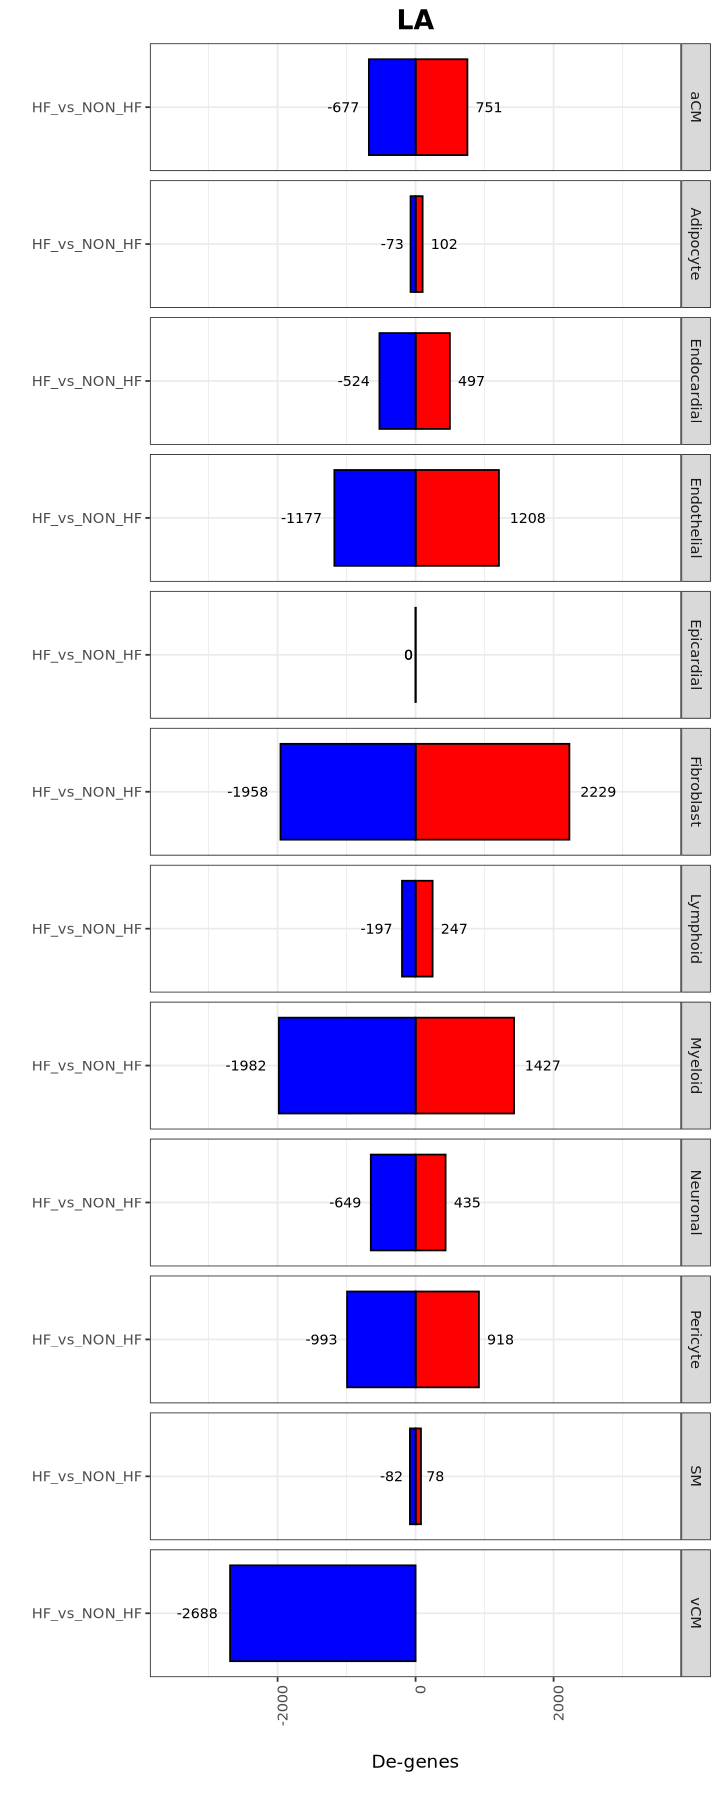

In [12]:
deseq.stats.plot = deseq.stats %>%
                  dplyr::select(celltype, contrast, up_padj, down_padj) %>%
                  pivot_longer(
                    cols = c(up_padj, down_padj),
                    names_to = "direction",
                    names_pattern = "([^_]+)_.*", # Captures everything before the underscore
                    values_to = "degenes") %>%
                 dplyr::mutate(direction = factor(direction, levels = c("up", "down")),
                              contrast = factor(contrast, levels = contrasts)) %>%
                 dplyr::mutate(degenes = if_else(direction == "down", -degenes, degenes))


options(repr.plot.width=6, repr.plot.height=15)
width = 1
# Plot with dynamic text positioning based on the sign of degenes
ggplot(deseq.stats.plot, aes(x = contrast, y = degenes, fill = direction, label = degenes)) +
  geom_bar(stat = "identity", color = "black") +
  scale_fill_manual(values = c("up" = "red", "down" = "blue")) + 
  theme_bw() +
  labs(title = "LA", x = "", y = " \n De-genes \n ") +
  ylim(-3500, 3500) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1),
        legend.position = "none", 
        plot.title = element_text(hjust = 0.5, face = "bold", size = 16)) +  
  geom_text(aes(hjust = ifelse(degenes > 0, -0.3, 1.3)),
            size = 3) +
  facet_nested(rows = vars(celltype), scales = "free", space = "free") +
  coord_flip()

In [13]:
write.table(deseq.stats, 
            paste0(outdir, "4Chambers_HFnonHF_ResultsSummaries.tsv"),
           quote=F, col.names=T, row.names=T, sep='\t')

In [116]:
# Plot some genes u like
genes.use = c("PTPN11", "JAK2", "FOXO1", "MAP3K3", "RPS6KA2", "BCL2", "FBXW11", "PTPN9", "MAP3K7", "STAT4")

TableGrob (2 x 5) "arrange": 10 grobs
         z     cells    name           grob
STAT4    1 (1-1,1-1) arrange gtable[layout]
FBXW11   2 (1-1,2-2) arrange gtable[layout]
MAP3K7   3 (1-1,3-3) arrange gtable[layout]
RPS6KA2  4 (1-1,4-4) arrange gtable[layout]
JAK2     5 (1-1,5-5) arrange gtable[layout]
PTPN11   6 (2-2,1-1) arrange gtable[layout]
FOXO1    7 (2-2,2-2) arrange gtable[layout]
PTPN9    8 (2-2,3-3) arrange gtable[layout]
MAP3K3   9 (2-2,4-4) arrange gtable[layout]
BCL2    10 (2-2,5-5) arrange gtable[layout]

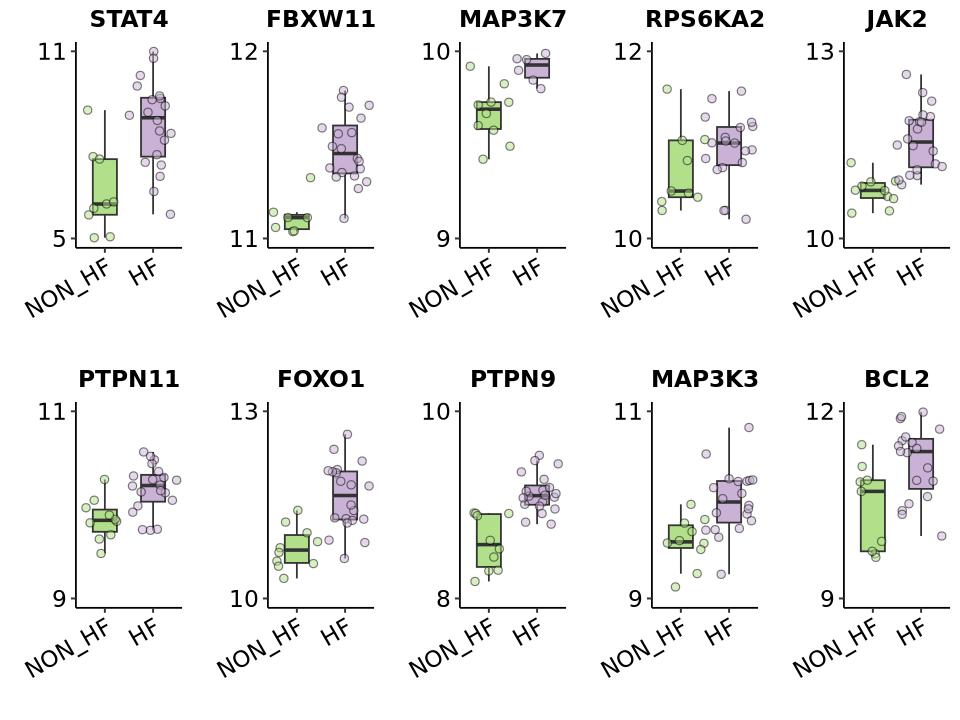

In [120]:
library(DESeq2)
library(ggplot2)
library(ggpubr)
library(dplyr)

# Apply Variance-Stabilizing Transformation (VST) to get normalized counts
dds_vst <- vst(dds, blind = FALSE)  # dds is your DESeqDataSet object
normalized_counts <- assay(dds_vst)  # Extract VST-normalized counts

# Convert to a long-format data frame for ggplot
counts_df <- as.data.frame(normalized_counts) %>%
  tibble::rownames_to_column("gene") %>%
  pivot_longer(-gene, names_to = "sample", values_to = "counts")

# Step 2: Merge with sample metadata (to include HF_status_base)
metadata_df <- colData(dds) %>%
  as.data.frame() %>%
  rownames_to_column("sample")%>%
  dplyr::select(sample, HF_status_base)

# Join the counts data with sample metadata
counts_merged <- counts_df %>%
  left_join(metadata_df, by = "sample") %>%
  dplyr::filter(gene %in% genes.use) %>%
  dplyr::mutate(HF_status_base = factor(HF_status_base, levels = c("NON_HF", "HF"))) %>%
  dplyr::mutate(gene = factor(gene, levels = genes.use))

# Initialize empty list to store plots
plot_list <- list()

# Loop through each gene
for (gene in unique(counts_merged$gene)) {
  
  # Subset data for the current gene
  gene_data <- counts_merged %>% dplyr::filter(gene == !!gene)
  
  # Determine min/max values and round up max
  min_val <- round(min(gene_data$counts, na.rm = TRUE))
  max_val <- round(max(gene_data$counts, na.rm = TRUE))
  
  # Create the box plot
  p <- ggplot(gene_data, aes(x = HF_status_base, y = counts, fill = HF_status_base)) +
    geom_boxplot(width = 0.5, outlier.shape = NA) +  
    scale_fill_manual(values = c("HF" = "#CAB2D6", "NON_HF" = "#B2DF8A")) +  # Custom fill colors
    geom_jitter(shape = 21, size = 2, width = 0.5, alpha = 0.5)+ 
    labs(title = gene, x = "HF Status", y = "Counts") +  # Title as gene name
    theme_pubr() +
    labs(x = "", y = "") +
    theme(
      plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),  # Centered title
      axis.text.x = element_text(angle = 30, hjust = 1, size = 14),
      axis.text.y = element_text(size = 14),
      axis.title = element_text(size = 14),
      legend.position = "none"  # Hide legend
    ) +
    scale_y_continuous(limits = c(min_val, max_val), breaks = c(min_val, max_val))  # Force 2 ticks (0 and max)

  # Store the plot in the list
  plot_list[[gene]] <- p
}

options(repr.plot.width = 8, repr.plot.height = 6)
# Arrange all plots in a grid
gg = grid.arrange(grobs = plot_list, nrow = 2)
gg

In [121]:
ggsave(filename = paste0("/nfs/lab/projects/mega_heart/Plots_figures/", "GRN_BACH2_Genes.pdf"),
                            width = 8, height = 6, 
                            plot = gg, device = "pdf")

In [122]:
# Plot some genes u like
genes.use = c("SLC8A1", "RYR2", "CACNB2", "SGCD", "TPM1", "TTN", "ADCY9", "ADCY5")

TableGrob (2 x 4) "arrange": 8 grobs
       z     cells    name           grob
RYR2   1 (1-1,1-1) arrange gtable[layout]
SLC8A1 2 (1-1,2-2) arrange gtable[layout]
TTN    3 (1-1,3-3) arrange gtable[layout]
ADCY5  4 (1-1,4-4) arrange gtable[layout]
SGCD   5 (2-2,1-1) arrange gtable[layout]
CACNB2 6 (2-2,2-2) arrange gtable[layout]
TPM1   7 (2-2,3-3) arrange gtable[layout]
ADCY9  8 (2-2,4-4) arrange gtable[layout]

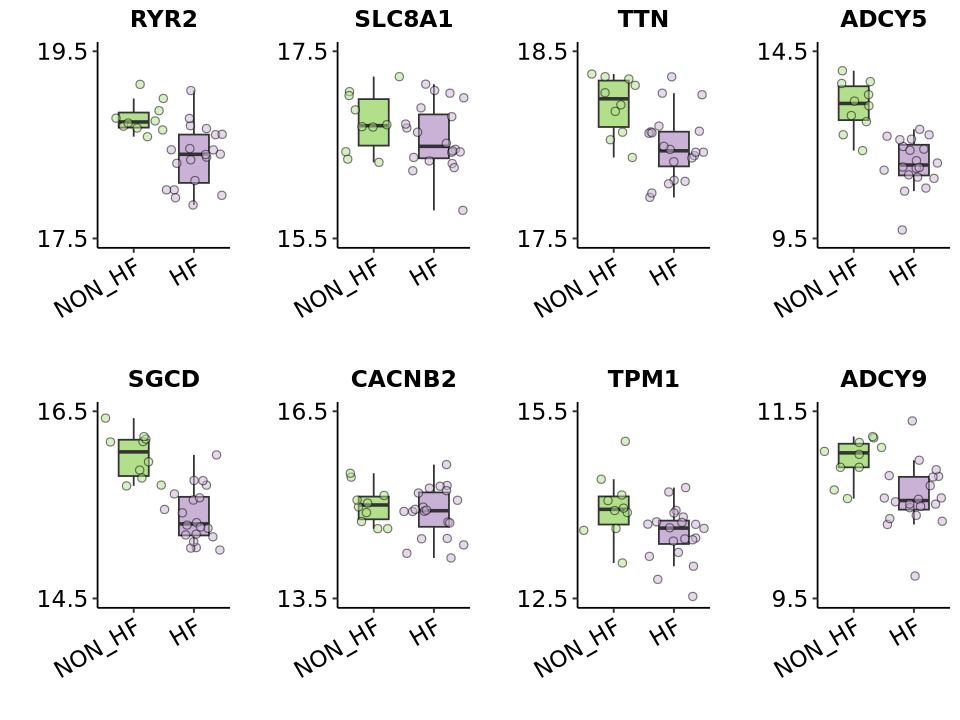

In [123]:
library(DESeq2)
library(ggplot2)
library(ggpubr)
library(dplyr)

# Apply Variance-Stabilizing Transformation (VST) to get normalized counts
dds_vst <- vst(dds, blind = FALSE)  # dds is your DESeqDataSet object
normalized_counts <- assay(dds_vst)  # Extract VST-normalized counts

# Convert to a long-format data frame for ggplot
counts_df <- as.data.frame(normalized_counts) %>%
  tibble::rownames_to_column("gene") %>%
  pivot_longer(-gene, names_to = "sample", values_to = "counts")

# Step 2: Merge with sample metadata (to include HF_status_base)
metadata_df <- colData(dds) %>%
  as.data.frame() %>%
  rownames_to_column("sample")%>%
  dplyr::select(sample, HF_status_base)

# Join the counts data with sample metadata
counts_merged <- counts_df %>%
  left_join(metadata_df, by = "sample") %>%
  dplyr::filter(gene %in% genes.use) %>%
  dplyr::mutate(HF_status_base = factor(HF_status_base, levels = c("NON_HF", "HF"))) %>%
  dplyr::mutate(gene = factor(gene, levels = genes.use))

# Initialize empty list to store plots
plot_list <- list()

# Loop through each gene
for (gene in unique(counts_merged$gene)) {
  
  # Subset data for the current gene
  gene_data <- counts_merged %>% dplyr::filter(gene == !!gene)
  
  # Determine min/max values and round up max
  min_val <- round(min(gene_data$counts, na.rm = TRUE))-0.5
  max_val <- round(max(gene_data$counts, na.rm = TRUE))+0.5
  
  # Create the box plot
  p <- ggplot(gene_data, aes(x = HF_status_base, y = counts, fill = HF_status_base)) +
    geom_boxplot(width = 0.5, outlier.shape = NA) +  
    scale_fill_manual(values = c("HF" = "#CAB2D6", "NON_HF" = "#B2DF8A")) +  # Custom fill colors
    geom_jitter(shape = 21, size = 2, width = 0.5, alpha = 0.5)+ 
    labs(title = gene, x = "HF Status", y = "Counts") +  # Title as gene name
    theme_pubr() +
    labs(x = "", y = "") +
    theme(
      plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),  # Centered title
      axis.text.x = element_text(angle = 30, hjust = 1, size = 14),
      axis.text.y = element_text(size = 14),
      axis.title = element_text(size = 14),
      legend.position = "none"  # Hide legend
    ) +
    scale_y_continuous(limits = c(min_val, max_val), breaks = c(min_val, max_val))  # Force 2 ticks (0 and max)

  # Store the plot in the list
  plot_list[[gene]] <- p
}

options(repr.plot.width = 8, repr.plot.height = 6)
# Arrange all plots in a grid
gg = grid.arrange(grobs = plot_list, nrow = 2)
gg

In [124]:
ggsave(filename = paste0("/nfs/lab/projects/mega_heart/Plots_figures/", "GRN_MEF2A_Genes.pdf"),
                            width = 8, height = 6, 
                            plot = gg, device = "pdf")

# FGSEA

In [14]:
GSEA.dir = "/nfs/lab/Luca/Assets/Gene.Sets/Categories/"

In [15]:
# Grab list of ribosomal proteins
rps <- fread('/nfs/lab/rlmelton/npod/notebooks/sherlock/Downstream_analysis_nPOD_april2022/Publication/Final_Downstream/rps_file_gsea.csv', fill=TRUE, header=TRUE)

In [ ]:
setwd(GSEA.dir)
gene.sets.ls = dir()

gene.set.db = NULL
for (i in seq_along(gene.sets.ls)){
    gene.set = gene.sets.ls[i]
    message("Processing ", gene.set)
    # Read in the GMT as a table, to get the name of the term
    gene.set.use = read.table(gene.set, sep = "\t", fill = TRUE)
    # Subset to just the first column
    gene.set.use = as.data.frame(gene.set.use[,1])
    colnames(gene.set.use) = "pathway"
    gene.set.use$term = as.factor(str_split_fixed(gene.set.use$pathway, pattern = "_", n = 2)[,2])
    gene.set.use$set = as.factor(str_split_fixed(gene.set.use$pathway, pattern = "_", n = 2)[,1])
            tmp = str_split_fixed(gene.set, pattern = "_", n = 2)[,2]
    gene.set.use$set.family = as.factor(str_split_fixed(tmp, pattern = "\\.", n = 2)[,1])
    gene.set.use$set.superfamily = as.factor(str_split_fixed(gene.set, pattern = "_", n = 2)[,1])

    gene.set.db = rbind(gene.set.db, gene.set.use)
}

gene.set.db$set.superfamily = factor(gene.set.db$set.superfamily, 
                                     levels = c("GO", "Targets", "Signatures", "Perturb",
                                                "CancerGS", "Positional"))
gene.set.db$set.family = factor(gene.set.db$set.family, 
                                     levels = c("BP", "CC", "MF",
                                                "CP", "Hallmarks", "Phenotypes",
                                                 "MiRNA", "TF",
                                                 "CellType","Immunogenic", "Oncogenic",
                                                 "ChemicalGenetic",
                                                 "Modules", "GenesNeighbors",
                                                 "CytogeneticBands"))

Processing CancerGS_GenesNeighbors.gmt.txt

Processing CancerGS_Modules.gmt.txt

Processing GO_BP.gmt.txt

Processing GO_CC.gmt.txt

Processing GO_CP.gmt.txt

Processing GO_Hallmarks.gmt.txt

Processing GO_MF.gmt.txt

Processing GO_Phenotypes.gmt.txt

Processing Perturb_ChemicalGenetic.gmt.txt

Processing Positional_CytogeneticBands.gmt.txt

Processing Signatures_CellType.gmt.txt

Processing Signatures_Immunogenic.gmt.txt



In [ ]:
# Load the pathways into a named list
GMT <- gmtPathways("/nfs/lab/Luca/Assets/Gene.Sets/msigdb.v2023.1.Hs.symbols.gmt")

In [ ]:
#Pseudobulk matrices directory
dir <- DESEQ.dir
#Create outdir for results
outdir <- GSEA.res.dir
# dir.create(outdir)
#Get list of pseudobulk files
files <- list.files(dir, pattern='.dds.res')
files

In [ ]:
set.seed(999)
# setup
tresh = 0.1
set.family.Keep = c("CP")

for (i in seq_along(files)){
    # load table
    file.use = files[i]
    De.analysis = str_split_fixed(file.use, ".dds.res", n = 2)[,1]
    print(paste0("Analyzing: ", De.analysis))
    res = read.table(paste0(dir,file.use), sep = '\t')
    
    # Remove ribosomal genes
    res <- res[!rownames(res) %in% rps$`Approved symbol`,]
    # Formatting for FGSEA
    res$rank = res$stat
    res = data.frame("SYMBOL" = rownames(res),
                     "stat" = res$rank)
    res = res[!grepl(pattern = "NA", x = res$SYMBOL),]
    ranks <- deframe(res)
    ranks = sort(ranks, decreasing=TRUE)
    
    tryCatch({
    message("Running FGSEA")
    fgseaRes <- fgseaMultilevel(pathways=GMT,
                                stats=ranks,
                                minSize  = 10, 
                                maxSize  = 500)
    message("Number of total enriched terms: ", nrow(fgseaRes))
    # Add categories
    fgseaRes = merge(fgseaRes, gene.set.db, by = "pathway") 

    # Subset for GO families of interest
    fgseaRes = fgseaRes[fgseaRes$set.family %in% set.family.Keep, ]
    message("Number of terms for families of interest: ", nrow(fgseaRes))

    # Subset to significant pathways
    fgseaRes.tresh = fgseaRes[fgseaRes$padj < tresh,]
    message("Number of significant terms: ", nrow(fgseaRes.tresh))

    # Collapse terms 
    collapsedPathways <- collapsePathways(fgseaRes.tresh[order(pval)][padj < tresh], 
                                          GMT, ranks)
    mainPathways <- fgseaRes.tresh[pathway %in% collapsedPathways$mainPathways][
                             order(-NES), pathway]
    fgseaResMain <- fgseaRes.tresh[match(mainPathways, pathway)]
    
    # Save them
    file = paste(outdir, "GSEA.CP_", De.analysis, "_all.res", sep = "")
    fwrite(fgseaRes, file = file, sep = "\t")
    
    file = paste(outdir, "GSEA.CP_", De.analysis, "_sig.res", sep = "")
    fwrite(fgseaRes.tresh, file = file, sep = "\t")
    
    file = paste(outdir, "GSEA.CP_", De.analysis, "_sig.collapsed.res", sep = "")
    fwrite(fgseaRes.tresh, file = file, sep = "\t")
        
    # print plot
    plot = ggplot(fgseaResMain, aes(x = reorder(term, NES), y = NES)) +
      geom_col(aes(fill= NES>0)) +
      theme_bw()+
      labs(x="", y="Normalized Enrichment Score",
           title= paste(De.analysis,
                        " \n Gene Ontologies")) + 
        theme(axis.text=element_text(size=10), axis.title=element_text(size=16, face="bold"),
        axis.text.x=element_text(), plot.title=element_text(size=16, face="bold", hjust=0.5)) +
      coord_flip() +
    facet_nested(rows = vars(set.family, set), drop = TRUE, scales = "free", space = "free")
    ggsave(filename = paste(outdir, "GSEA.CP_", De.analysis, ".pdf", sep = ""),
                            height = 16, width = 20,
                            plot = plot, device = "pdf")
        }, error = function(e) {
    message("Error or no results found for ", De.analysis, ": ", e$message)
})
}